# Лабораторные работы 1-5 (Медведев К.В.)

# ЛР 1 (KNN)



Датасеты для задач классификации и регрессии, метрики моделей, а также обоснования их выбора приведены в `README.md` файле репозитория.

In [705]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Задача классификации

#### Предобработка датасета `salary.csv`

In [609]:
salary_df = pd.read_csv('datasets/salary.csv')

salary_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Оценим число людей получающих более 50'000$ и менее, именно по этому признаку мы будем их классифицировать.

In [610]:
salary_df['salary'].value_counts()

salary
<=50K    24720
>50K      7841
Name: count, dtype: int64

О датасете заранее известно что пропущенные данные обозначены символом `?`. Заменим его на Nan и обработаем пустые значения.

In [611]:
salary_df.replace(' ?' , np.nan ,inplace=True)
salary_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

Имеем пустые значения в колонках:
- `workclass` (тип занятости: частный сектор, государственная работа и тд.)
- `occupation` (профессия: продажи, административная должность, мэнеджеры и тд.)
- `native-country` (страна проихсождения)

Заменим `Nan` в этих колонках на `Other`, `Other`, `Other-service` соответственно.

In [612]:
salary_df[ 'workclass' ] = salary_df[ 'workclass' ].fillna('Other-service')
salary_df[ 'occupation' ] = salary_df[ 'occupation' ].fillna('Other')
salary_df[ 'native-country' ] = salary_df[ 'native-country' ].fillna('Other')

Явно отметим колонки с категориальными данными.

In [613]:
categoric_columns_salary = salary_df.select_dtypes(include=[ 'object' ]).columns
for column_name in categoric_columns_salary:
    print(column_name)

workclass
education
marital-status
occupation
relationship
race
sex
native-country
salary


Явно отметим колонки с числовыми данными

In [614]:
numeric_columns_salary = salary_df.select_dtypes(include=[ 'number' ]).columns
for column_name in numeric_columns_salary:
    print(column_name)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week


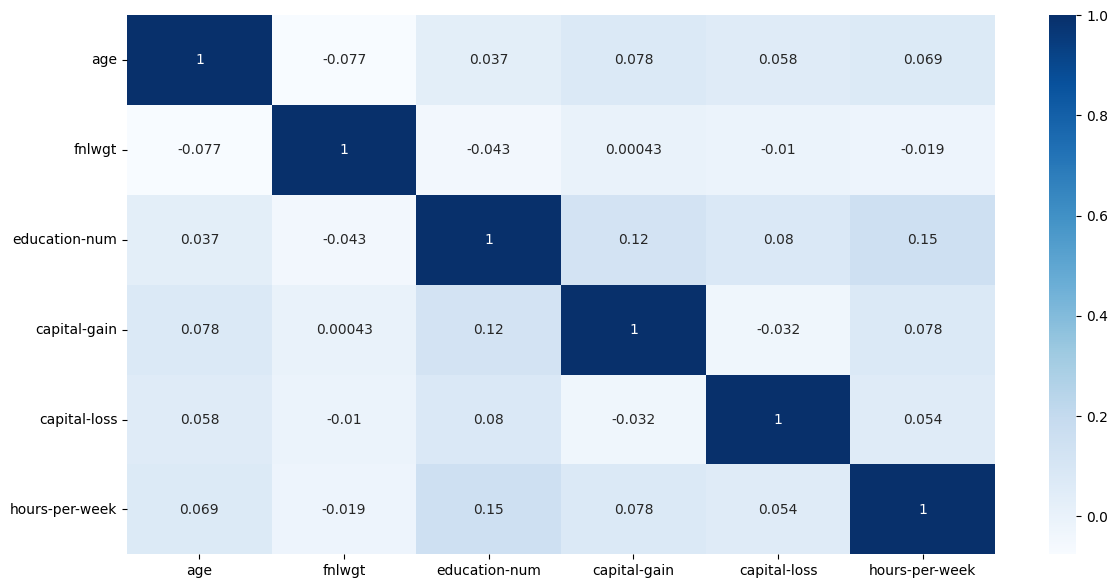

In [615]:
plt.figure(figsize = (14,7))
sns.heatmap(salary_df.select_dtypes(include=[ 'number' ]).corr() , annot=True , cmap = 'Blues')
plt.show()

Колонка `education-num` являет собой численную интерпретацию колокнки `education`, удалим вторую.

In [616]:
salary_df = salary_df.drop(columns=['education'])

categoric_columns_salary = categoric_columns_salary.tolist()
categoric_columns_salary.remove('education')
categoric_columns_salary = pd.Index(categoric_columns_salary)

Оценим категориальные переменные. И преобразуем их техникой `Label Encoding`, `One-Hot-Encoding`.

In [617]:
for column_name in categoric_columns_salary:
    print(salary_df[column_name].value_counts())
    print()

workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
Other-service         1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64

marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
Other                 1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: count, dtype: int64

relationship
Husba

In [618]:
encoder = LabelEncoder()

def preprocess(df):
    # Remove duplicates
    df = df.drop_duplicates()

    # Label encoding for categorical features
    df['salary'] = encoder.fit_transform(df['salary'])
    df['sex'] = encoder.fit_transform(df['sex'])
    df['native-country'] = encoder.fit_transform(df['native-country'])
    df['marital-status'] = encoder.fit_transform(df['marital-status'])

    # Cleaning and transforming workclass
    df['workclass'] = df['workclass'].str.strip()
    allowed_workclass = ['Private', 'Self-emp-not-inc', 'Local-gov']
    df['workclass'] = df['workclass'].apply(lambda val: val if val in allowed_workclass else 'other')

    # One-hot encoding for workclass, race, and relationship
    df = pd.get_dummies(df, columns=['workclass'], drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['race'], drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['relationship'], drop_first=True, dtype=int)

    # Cleaning and encoding occupation
    df['occupation'] = df['occupation'].str.strip()
    mode_value = df['occupation'].mode()[0]
    df['occupation'] = df['occupation'].replace('?', mode_value)
    df['occupation'] = encoder.fit_transform(df['occupation'])

    return df

salary_df = preprocess(salary_df)

salary_df.head()

,age,fnlwgt,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,...,workclass_other,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,39,77516,13,4,0,1,2174,0,40,38,...,1,0,0,0,1,1,0,0,0,0
1,50,83311,13,2,3,1,0,0,13,38,...,0,0,0,0,1,0,0,0,0,0
2,38,215646,9,0,5,1,0,0,40,38,...,0,0,0,0,1,1,0,0,0,0
3,53,234721,7,2,5,1,0,0,40,38,...,0,0,1,0,0,0,0,0,0,0
4,28,338409,13,2,10,0,0,0,40,4,...,0,0,1,0,0,0,0,0,0,1


In [619]:
salary_df = salary_df.drop(['fnlwgt'], axis=1)

#### Бейзлайн

In [ ]:
X = salary_df.drop('salary' , axis = 1).values
y = salary_df['salary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , stratify=y, random_state=42)

knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(X_train, y_train)

y_get = knn_class.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_get)}")
print(f"Precision: {precision_score(y_test, y_get)}")
print(f"Recall: {recall_score(y_test, y_get)}")
print(f"F1-score: {f1_score(y_test, y_get)}")

Accuracy: 0.842040565457898
Precision: 0.6866359447004609
Recall: 0.6335034013605442
F1-score: 0.659000442282176


#### Улучшенный бейзлайн

- Создадим новый признак `net_capital_flow` из связанных `capital-gain` и `capital-loss`.
- Применим метод `PowerTransformer` для нормализации столбца `age`, что уменьшит влияние выбросов и приведет данные к более симметричному распределению.
- Используем метод `SMOTEENN` для синтеза новых данных и удаления шумовых. Это улучшит модель, обучая ее на более сбалансированных данных.
- Изменим количество соседей с 5 на 8.

In [205]:
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

X = salary_df.drop('salary' , axis = 1).values
y = salary_df['salary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , stratify=y, random_state=42)

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42)

knn_class = KNeighborsClassifier(n_neighbors=8)
knn_class.fit(X_train_enn, y_train_enn)

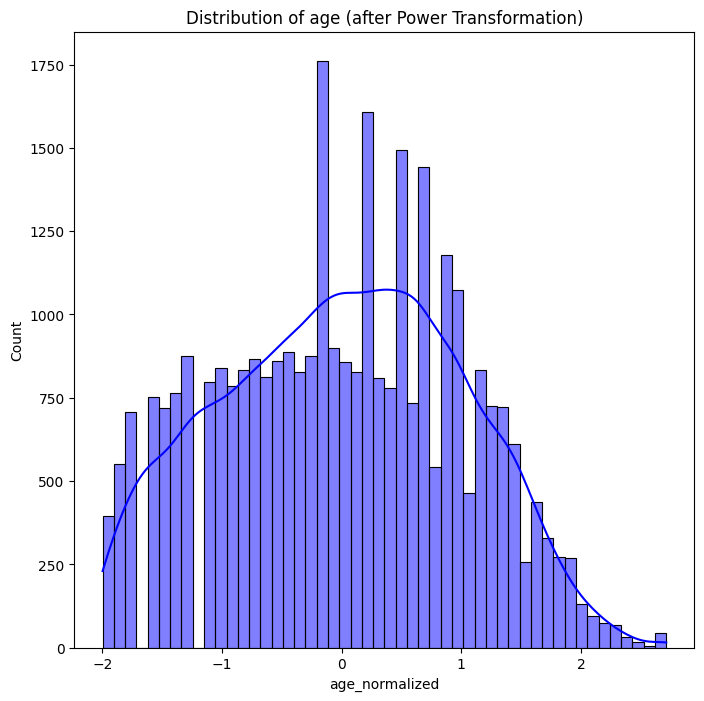

In [210]:
plt.figure(figsize=(8, 8))
sns.histplot(salary_df['age_normalized'], kde=True, color='blue', alpha=0.5)
plt.title("Distribution of age (after Power Transformation)")
plt.show()

In [208]:
y_get = knn_class.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_get)}")
print(f"Precision: {precision_score(y_test, y_get)}")
print(f"Recall: {recall_score(y_test, y_get)}")
print(f"F1-score: {f1_score(y_test, y_get)}")

Accuracy: 0.8191968858840402
Precision: 0.5805212620027435
Recall: 0.8996598639455783
F1-score: 0.7056861764215441


#### Самостоятельная имплементация

In [214]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    # Метод для расчета евклидова расстояния
    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    # Метод для подбора ближайших соседей
    def get_neighbors(self, X_train, X_test_point):
        distances = np.array([self.euclidean_distance(X_test_point, train_point) for train_point in X_train])
        sorted_idx = np.argsort(distances)
        return sorted_idx[:self.k]

    # Метод для обучения модели (не требуется для KNN, так как это ленивый алгоритм)
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # Метод для предсказания метки для одного тестового примера
    def predict_one(self, X_test_point):
        neighbors_idx = self.get_neighbors(self.X_train, X_test_point)
        neighbors_labels = self.y_train[neighbors_idx]
        most_common = Counter(neighbors_labels).most_common(1)
        return most_common[0][0]

    # Метод для предсказания всех тестовых данных
    def predict(self, X_test):
        return np.array([self.predict_one(test_point) for test_point in X_test])


knn = KNN(k=8)
knn.fit(X_train_enn, y_train_enn)

y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

Accuracy: 0.8155091169842246
Precision: 0.5731351207857712
Recall: 0.9179421768707483
F1-score: 0.7056708612518385


### Задача регрессии

#### Предобработка датасета `energy.csv`

In [659]:
energy_df = pd.read_csv('datasets/energy.csv')

energy_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Переименуем колонки согласно значениям, хранимым в них. Признаки и целевые переменные имеют числовой формат.

In [660]:
energy_df.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height',
                     'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

energy_df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


В датасете отсутствуют пропуски.

In [661]:
energy_df.isna().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
cooling_load                 0
dtype: int64

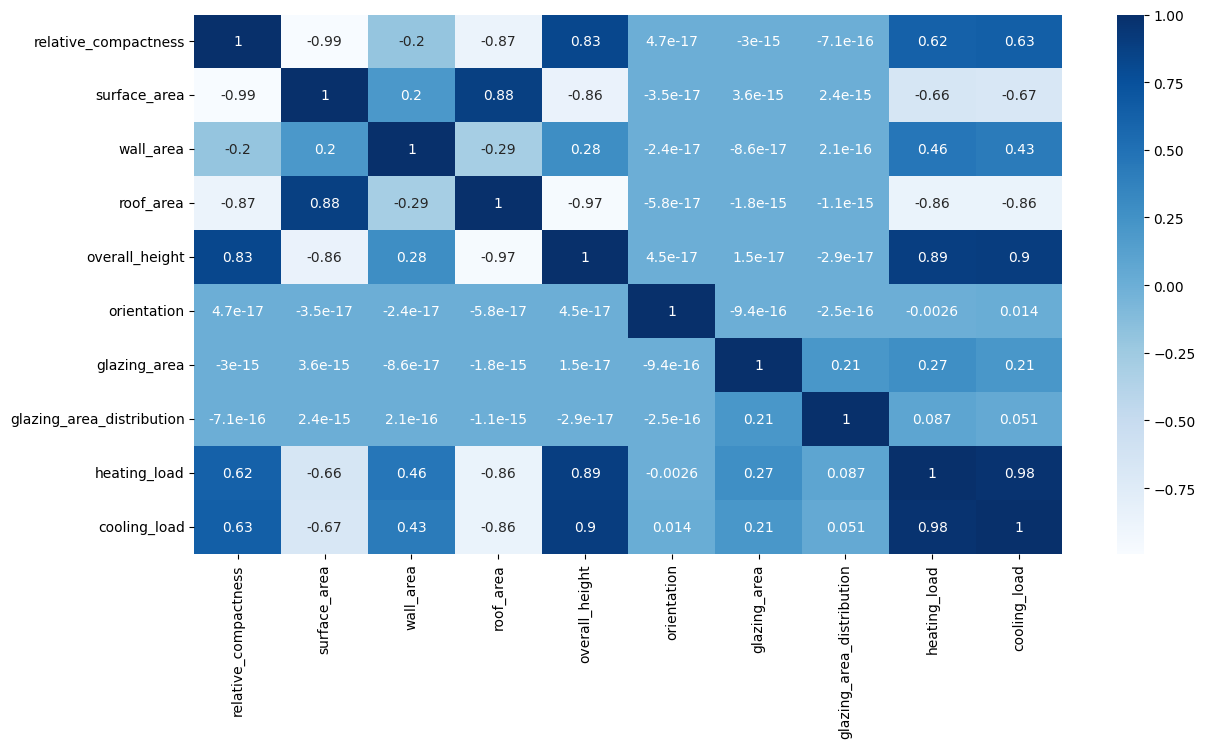

In [658]:
plt.figure(figsize = (14,7))
sns.heatmap(energy_df.corr() , annot=True , cmap = 'Blues')
plt.show()

#### Бейзлайн

In [640]:
X = energy_df.drop(['heating_load','cooling_load'], axis=1)
y = energy_df[['heating_load','cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

y_get = knn_reg.predict(X_test)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_get)}")
print(f"R-squared (R^2): {r2_score(y_test, y_get)}")

Mean Absolute Error (MAE): 1.6515800865800876
R-squared (R^2): 0.9464525135915605


#### Улучшенный бейзлайн

- Оптимизируем гиперпараметры.

In [653]:
X = energy_df.drop(['heating_load','cooling_load'], axis=1)
y = energy_df[['heating_load','cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Количество соседей
    'weights': ['uniform', 'distance'],  # Веса
    'metric': ['euclidean', 'manhattan']  # Метрика расстояния
}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_knn = grid_search.best_estimator_

y_get = best_knn.predict(X_test)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_get)}")
print(f"R-squared (R^2): {r2_score(y_test, y_get)}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Mean Absolute Error (MAE): 1.5880375180375197
R-squared (R^2): 0.9561152647251427


#### Самостоятельная имплементация

In [657]:
# Функция для вычисления расстояний
def compute_distances(X_train, X_test, metric='euclidean'):
    if metric == 'euclidean':
        return distance.cdist(X_test, X_train, 'euclidean')
    elif metric == 'manhattan':
        return distance.cdist(X_test, X_train, 'cityblock')
    else:
        raise ValueError("Unsupported metric. Use 'euclidean' or 'manhattan'.")

# Самописный алгоритм KNN для регрессии
class MyKNNRegressor:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X_test = np.array(X)
        distances = compute_distances(self.X_train, X_test, metric=self.metric)
        predictions = []

        for dist in distances:
            neighbors_idx = np.argsort(dist)[:self.n_neighbors]  # Индексы ближайших соседей
            neighbors_values = self.y_train[neighbors_idx]

            if self.weights == 'uniform':
                predictions.append(np.mean(neighbors_values, axis=0))
            elif self.weights == 'distance':
                inv_distances = 1 / (dist[neighbors_idx] + 1e-9)  # Избегаем деления на 0
                weighted_avg = np.average(neighbors_values, axis=0, weights=inv_distances)
                predictions.append(weighted_avg)
            else:
                raise ValueError("Unsupported weights. Use 'uniform' or 'distance'.")
        return np.array(predictions)

# Поиск оптимальных гиперпараметров
def grid_search_knn(X_train, y_train, X_test, y_test, param_grid):
    best_params = None
    best_score = float('inf')

    for n_neighbors in param_grid['n_neighbors']:
        for weights in param_grid['weights']:
            for metric in param_grid['metric']:
                knn = MyKNNRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)
                mae = mean_absolute_error(y_test, y_pred)
                if mae < best_score:
                    best_score = mae
                    best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

    return best_params, best_score

# Данные
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1).values
y = energy_df[['heating_load', 'cooling_load']].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Сетка гиперпараметров
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Поиск лучших параметров
best_params, best_score = grid_search_knn(X_train, y_train, X_test, y_test, param_grid)
print("Best parameters:", best_params)


# Применение лучшей модели
best_knn = MyKNNRegressor(**best_params)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Best parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Mean Absolute Error (MAE): 1.5606854256854266
R-squared (R^2): 0.9569268834405515


# ЛР 2 (Линейные модели)

### Задача классификации

#### Бейзлайн

In [311]:
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Обучение модели логистической регрессии
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Предсказание
y_get = log_reg.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7946117598852694
Precision: 0.6423297785069729
Recall: 0.33290816326530615
F1-score: 0.4385326239148698


#### Улучшенный бейзлайн

- Создадим новый признак `net_capital_flow` из связанных `capital-gain` и `capital-loss`.
- Применим метод `PowerTransformer` для нормализации столбца `age`, что уменьшит влияние выбросов и приведет данные к более симметричному распределению.
- Используем метод `SMOTEENN` для синтеза новых данных и удаления шумовых. Это улучшит модель, обучая ее на более сбалансированных данных.

In [375]:
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

X = salary_df.drop('salary' , axis = 1).values
y = salary_df['salary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , stratify=y, random_state=42)

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_enn, y_train_enn)
y_get = log_reg.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_get)}")
print(f"Precision: {precision_score(y_test, y_get)}")
print(f"Recall: {recall_score(y_test, y_get)}")
print(f"F1-score: {f1_score(y_test, y_get)}")

Accuracy: 0.7045687359147715
Precision: 0.43935248518011855
Recall: 0.8193027210884354
F1-score: 0.5719798159691303


#### Самостоятельная имплементация

In [ ]:
class LogisticRegressionManual:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for i in range(self.iterations):
            # Прогноз
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # Вычисление градиентов
            dw = (1/m) * np.dot(X.T, (y_pred - y))
            db = (1/m) * np.sum(y_pred - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_pred]

X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

model = LogisticRegressionManual(learning_rate=0.01, iterations=1000)
model.fit(X_resampled_enn, y_resampled_enn)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

Accuracy: 0.7402171686129891
Precision: 0.4699934768427919
Recall: 0.6126700680272109
F1-score: 0.5319306016980435


### Задача регрессии

#### Бейзлайн

In [665]:
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Предсказание
y_pred = lin_reg.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")

Mean Absolute Error (MAE): 2.2066226634811703
R-squared (R^2): 0.8994149873458703


#### Улучшенный бейзлайн

- Нормализуем данные с помощью `StandardScaller`
- Добавим полиномиальные признаки для улучшения модели
- Подберем оптимальные гиперпараметры
- Используем регуляризацию `Ridge`

In [668]:
# Разделение данных
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Добавление полиномиальных признаков для улучшения модели
poly = PolynomialFeatures(degree=2, include_bias=False)  # Степень 2
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Линейная регрессия с L2 регуляризацией (Ridge)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Регуляризационный параметр
    'fit_intercept': [True, False]  # Включение или исключение свободного члена
}

ridge_reg = Ridge()
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_poly, y_train)

print("Best parameters:", grid_search.best_params_)

# Получаем лучшую модель
best_ridge_reg = grid_search.best_estimator_

# Предсказания
y_pred = best_ridge_reg.predict(X_test_poly)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Best parameters: {'alpha': 0.01, 'fit_intercept': False}
Mean Absolute Error (MAE): 1.2047492592491433
R-squared (R^2): 0.9723122966407316


#### Самостоятельная имплементация

In [671]:
# Реализация линейной регрессии с L2 регуляризацией (Ridge)
class LinearRegressionWithRidge:
    def __init__(self, alpha=1.0, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Добавляем столбец для свободного члена (если fit_intercept=True)
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        
        # Регуляризация (Ridge) — решение задачи минимизации потерь с добавлением L2 нормы
        # Формула для решения: (X.T * X + alpha * I)^(-1) * X.T * y
        # Где I - единичная матрица, alpha - параметр регуляризации
        XTX = np.dot(X.T, X) + self.alpha * np.eye(X.shape[1])
        XTy = np.dot(X.T, y)
        self.coef_ = np.linalg.solve(XTX, XTy)
        
        if self.fit_intercept:
            self.intercept_ = self.coef_[0]
            self.coef_ = self.coef_[1:]
        else:
            self.intercept_ = 0

    def predict(self, X):
        # Если есть свободный член
        if self.fit_intercept:
            return np.dot(X, self.coef_) + self.intercept_
        else:
            return np.dot(X, self.coef_)

# Реализация кросс-валидации для подбора гиперпараметров
def cross_validate(model, X, y, param_grid, cv=5):
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Перебор всех параметров из grid
    for alpha in param_grid['alpha']:
        for fit_intercept in param_grid['fit_intercept']:
            # Создаем модель с текущими параметрами
            model.alpha = alpha
            model.fit_intercept = fit_intercept
            
            # Кросс-валидация
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            scores = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                score = mean_absolute_error(y_val, y_pred)
                scores.append(score)
            
            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_params = {'alpha': alpha, 'fit_intercept': fit_intercept}
                best_model = model
                
    return best_model, best_params, best_score

# Загрузка данных
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1).values
y = energy_df[['heating_load', 'cooling_load']].values

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Полиномиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)  # Степень 2
X_poly = poly.fit_transform(X_scaled)

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Настройка параметров модели
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Регуляризационный параметр
    'fit_intercept': [True, False]  # Включение или исключение свободного члена
}

# Инициализация модели и кросс-валидация
model = LinearRegressionWithRidge()
best_model, best_params, best_score = cross_validate(model, X_train, y_train, param_grid, cv=5)

# Вывод лучших параметров
print("Best parameters:", best_params)

# Предсказания лучшей модели
y_pred = best_model.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Best parameters: {'alpha': 0.01, 'fit_intercept': False}
Mean Absolute Error (MAE): 3.928335746276144
R-squared (R^2): 0.6715282956733065


# ЛР 3 (Решающее дерево)

### Задача классификации

#### Бейзлайн

In [404]:
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Обучение модели решающего дерева
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# Предсказание
y_get = dtree.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.8202212661339889
Precision: 0.62905317769131
Recall: 0.6186224489795918
F1-score: 0.6237942122186495


#### Улучшенный бейзлайн

- Создадим новый признак `net_capital_flow` из связанных `capital-gain` и `capital-loss`.
- Применим метод `PowerTransformer` для нормализации столбца `age`, что уменьшит влияние выбросов и приведет данные к более симметричному распределению.
- Используем метод `SMOTEENN` для синтеза новых данных и удаления шумовых. Это улучшит модель, обучая ее на более сбалансированных данных.

In [405]:
# Преобразование и создание новых признаков
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

# Нормализация возраста
pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

# Удаляем старые признаки
salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

# Разделяем данные на признаки (X) и целевую переменную (y)
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Применяем SMOTEENN для балансировки классов
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

# Разделяем сбалансированные данные на обучающую и тестовую выборки
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42)

# Обучаем модель решающего дерева
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_enn, y_train_enn)

# Предсказание на тестовой выборке
y_get = decision_tree.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8590452776070477
Precision: 0.6539432176656151
Recall: 0.8813775510204082
F1-score: 0.7508149221296632


#### Самостоятельная имплементация

In [458]:
import numpy as np
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Проверка на пустые подмножества
        if len(set(y)) == 1:
            return y[0]
        
        # Если достигнута максимальная глубина или нет возможности для дальнейшего разбиения
        if self.max_depth is not None and depth >= self.max_depth:
            return self._majority_class(y)

        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            return self._majority_class(y)

        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask

        # Проверка на пустые подмножества
        if len(X[left_mask]) == 0 or len(X[right_mask]) == 0:
            return self._majority_class(y)

        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return (feature_index, threshold, left_tree, right_tree)

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        m, n = X.shape

        # Пробуем разбиение по каждому признаку
        for feature_index in range(n):
            thresholds = set(X[:, feature_index])  # Все уникальные значения признака

            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask

                # Если одно из подмножеств пусто, пропускаем разбиение
                if len(X[left_mask]) == 0 or len(X[right_mask]) == 0:
                    continue

                gini = self._gini_impurity(y[left_mask], y[right_mask])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, left, right):
        # Оценка качества разбиения с помощью критерия Джини
        left_size = len(left)
        right_size = len(right)
        total_size = left_size + right_size

        left_proportion = Counter(left)
        right_proportion = Counter(right)

        gini_left = 1 - sum((count / left_size) ** 2 for count in left_proportion.values())
        gini_right = 1 - sum((count / right_size) ** 2 for count in right_proportion.values())

        return (left_size / total_size) * gini_left + (right_size / total_size) * gini_right

    def _majority_class(self, y):
        # Возвращает наиболее часто встречающийся класс
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return [self._predict_single(x, self.tree) for x in X]

    def _predict_single(self, x, tree):
        if isinstance(tree, tuple):
            feature_index, threshold, left_tree, right_tree = tree
            if x[feature_index] <= threshold:
                return self._predict_single(x, left_tree)
            else:
                return self._predict_single(x, right_tree)
        else:
            return tree

# Пример использования:
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Применяем SMOTEENN для балансировки классов
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

# Разделяем сбалансированные данные на обучающую и тестовую выборки
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42)

# Обучаем модель самописного решающего дерева
tree = DecisionTree(max_depth=5)
tree.fit(X_train_enn, y_train_enn)

# Предсказание на тестовой выборке
y_get = tree.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.7863142798606843
Precision: 0.5344559585492228
Recall: 0.877125850340136
F1-score: 0.6641983258209916


### Задача регрессии

#### Бейзлайн

In [673]:
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель решающего дерева
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = dt_reg.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")

Mean Absolute Error (MAE): 0.7462337662337661
R-squared (R^2): 0.9744467116063398


#### Улучшенный бейзлайн

- Оптимизируем гиперпараметры

In [674]:
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение модели решающего дерева
dt_reg = DecisionTreeRegressor(random_state=42)

# Определение гиперпараметров для перебора
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

# Использование GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=dt_reg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print(f"Best hyperparameters: {grid_search.best_params_}")

# Обучение модели с лучшими гиперпараметрами
best_dt_reg = grid_search.best_estimator_

# Предсказание на тестовой выборке
y_pred = best_dt_reg.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best hyperparameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean Absolute Error (MAE): 0.8340541297327009
R-squared (R^2): 0.9752233976439652


#### Самостоятельная имплементация

In [687]:

class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def _mse(self, y):
        # Среднеквадратичная ошибка для целевых переменных
        return np.mean((y - np.mean(y, axis=0)) ** 2)

    def _best_split(self, X, y):
        # Ищем наилучшее разбиение данных
        best_mse = float('inf')
        best_split = None
        best_left_y = None
        best_right_y = None
        best_left_X = None
        best_right_X = None
        for feature in X.columns:
            values = X[feature].unique()
            for value in values:
                left_mask = X[feature] <= value
                right_mask = ~left_mask
                left_y = y[left_mask]
                right_y = y[right_mask]
                mse = (len(left_y) * self._mse(left_y) + len(right_y) * self._mse(right_y)) / (len(left_y) + len(right_y))
                if mse < best_mse:
                    best_mse = mse
                    best_split = (feature, value)
                    best_left_y = left_y
                    best_right_y = right_y
                    best_left_X = X[left_mask]
                    best_right_X = X[right_mask]
        return best_split, best_left_X, best_left_y, best_right_X, best_right_y

    def _build_tree(self, X, y, depth=0):
        # Рекурсивная постройка дерева решений
        if len(set(tuple(row) for row in y.values)) == 1:  # Останавливаемся, если все значения одинаковы
            return np.mean(y, axis=0)
        if self.max_depth and depth >= self.max_depth:
            return np.mean(y, axis=0)
        
        split, left_X, left_y, right_X, right_y = self._best_split(X, y)
        if split is None:
            return np.mean(y, axis=0)
        
        left_tree = self._build_tree(left_X, left_y, depth + 1)
        right_tree = self._build_tree(right_X, right_y, depth + 1)
        
        return {'split': split, 'left': left_tree, 'right': right_tree}
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
    
    def _predict_one(self, x, tree):
        # Прогнозирование для одной строки
        if isinstance(tree, dict):
            feature, value = tree['split']
            if x[feature] <= value:
                return self._predict_one(x, tree['left'])
            else:
                return self._predict_one(x, tree['right'])
        else:
            return tree
    
    def predict(self, X):
        return X.apply(lambda row: self._predict_one(row, self.tree), axis=1)

# Разделение данных на признаки (X) и целевые переменные (y)
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение модели
model = CustomDecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Mean Absolute Error (MAE): 1.0218680687704027
R-squared (R^2): 0.9728272577240737


# ЛР 4 (Случайный лес)

### Задача классификации

#### Бейзлайн

In [470]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Подготовка данных
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Обучение модели случайного леса
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf.fit(X_train, y_train)

# Предсказание
y_get = rf.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8519770538824012
Precision: 0.721760391198044
Recall: 0.6275510204081632
F1-score: 0.6713668410279736


#### Улучшенный бейзлайн

- Создадим новый признак `net_capital_flow` из связанных `capital-gain` и `capital-loss`.
- Применим метод `PowerTransformer` для нормализации столбца `age`, что уменьшит влияние выбросов и приведет данные к более симметричному распределению.
- Используем метод `SMOTEENN` для синтеза новых данных и удаления шумовых. Это улучшит модель, обучая ее на более сбалансированных данных.
- Оптимизируем гиперпараметры

In [496]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Подготовка данных
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']
pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])
salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Балансировка классов
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

# Разделение данных
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(
    X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42
)

# Грид для гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [3, 5, 10, None],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество выборок для разбиения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество выборок в листе
    'max_features': ['sqrt', 'log2', None]  # Количество признаков при разбиении
}

# Инициализация модели
rf = RandomForestClassifier(random_state=42)

# GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_enn, y_train_enn)

# Лучшие параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Оценка модели с лучшими параметрами
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8686744519565662
Precision: 0.6714743589743589
Recall: 0.8907312925170068
F1-score: 0.7657163742690059


#### Самостоятельная имплементация

In [580]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from concurrent.futures import ThreadPoolExecutor

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Проверка на пустые подмножества
        if len(set(y)) == 1:
            return y[0]
        
        # Если достигнута максимальная глубина или нет возможности для дальнейшего разбиения
        if self.max_depth is not None and depth >= self.max_depth:
            return self._majority_class(y)

        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            return self._majority_class(y)

        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask

        # Проверка на пустые подмножества
        if len(X[left_mask]) == 0 or len(X[right_mask]) == 0:
            return self._majority_class(y)

        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return (feature_index, threshold, left_tree, right_tree)

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        m, n = X.shape

        # Пробуем разбиение по каждому признаку
        for feature_index in range(n):
            thresholds = np.unique(X[:, feature_index])  # Уникальные значения признака

            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask

                # Если одно из подмножеств пусто, пропускаем разбиение
                if len(X[left_mask]) == 0 or len(X[right_mask]) == 0:
                    continue

                gini = self._gini_impurity(y[left_mask], y[right_mask])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, left, right):
        left_size = len(left)
        right_size = len(right)
        total_size = left_size + right_size

        left_proportion = Counter(left)
        right_proportion = Counter(right)

        gini_left = 1 - sum((count / left_size) ** 2 for count in left_proportion.values())
        gini_right = 1 - sum((count / right_size) ** 2 for count in right_proportion.values())

        return (left_size / total_size) * gini_left + (right_size / total_size) * gini_right

    def _majority_class(self, y):
        # Возвращает наиболее часто встречающийся класс
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return [self._predict_single(x, self.tree) for x in X]

    def _predict_single(self, x, tree):
        if isinstance(tree, tuple):
            feature_index, threshold, left_tree, right_tree = tree
            if x[feature_index] <= threshold:
                return self._predict_single(x, left_tree)
            else:
                return self._predict_single(x, right_tree)
        else:
            return tree

class MyRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(self._train_tree, X, y) for _ in range(self.n_estimators)]
            for future in futures:
                self.trees.append(future.result())

    def _train_tree(self, X, y):
        # Сэмплирование с возвращением
        idx = np.random.choice(len(X), size=len(X), replace=True)
        X_sample, y_sample = X[idx], y[idx]

        # Обучаем дерево на случайном подмножестве данных
        tree = DecisionTree(max_depth=self.max_depth)
        tree.fit(X_sample, y_sample)
        return tree

    def predict(self, X):
        # Собираем предсказания от всех деревьев
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Возвращаем наиболее частое предсказание
        return [Counter(pred).most_common(1)[0][0] for pred in predictions.T]

# Подготовка данных
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Обучение модели случайного леса
rf = MyRandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# Предсказание
y_get = rf.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8440893259577955
Precision: 0.6955702167766258
Recall: 0.6275510204081632
F1-score: 0.6598122485471614


### Задача регрессии

#### Бейзлайн

In [689]:
# Разделение на обучающую и тестовую выборки
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель случайного леса
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rf_reg.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Mean Absolute Error (MAE): 0.7099976190476174
R-squared (R^2): 0.9811305513221575


#### Улучшенный бейзлайн

- Оптимизируем гиперпараметры

In [690]:
# Разделение на обучающую и тестовую выборки
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],        # Количество деревьев
    'max_depth': [None, 10, 20, 30],        # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],        # Минимальное количество выборок для разделения
    'min_samples_leaf': [1, 2, 4],          # Минимальное количество выборок в листе
    'max_features': ['auto', 'sqrt', 'log2']  # Количество признаков для разбиения
}

# Инициализация модели случайного леса
rf_reg = RandomForestRegressor(random_state=42)

# Настроим GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Best parameters:", grid_search.best_params_)

# Получаем лучшую модель
best_rf_reg = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred = best_rf_reg.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error (MAE): 0.6953030303030266
R-squared (R^2): 0.9844953613012803


#### Самостоятельная имплементация

In [693]:
class CustomDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_targets = y.shape[1]

        # Если достигнута максимальная глубина или минимальное количество выборок
        if (self.max_depth and depth >= self.max_depth) or n_samples <= self.min_samples_leaf:
            return np.mean(y, axis=0)

        # Поиск наилучшего разделения
        best_split = self._best_split(X, y)
        if best_split is None:
            return np.mean(y, axis=0)

        left_idx, right_idx = best_split['left'], best_split['right']
        left_tree = self._build_tree(X.iloc[left_idx], y.iloc[left_idx], depth + 1)
        right_tree = self._build_tree(X.iloc[right_idx], y.iloc[right_idx], depth + 1)

        return {'feature': best_split['feature'], 'value': best_split['value'],
                'left': left_tree, 'right': right_tree}

    def _best_split(self, X, y):
        best_mse = float('inf')
        best_split = None
        n_samples, n_features = X.shape

        # Перебор всех признаков и всех возможных разделений
        for feature in range(n_features):
            values = X.iloc[:, feature].unique()
            for value in values:
                left_idx = np.where(X.iloc[:, feature].values <= value)[0]
                right_idx = np.where(X.iloc[:, feature].values > value)[0]

                if len(left_idx) < self.min_samples_split or len(right_idx) < self.min_samples_split:
                    continue

                left_y, right_y = y.iloc[left_idx], y.iloc[right_idx]
                mse = self._compute_mse(left_y, right_y)
                if mse < best_mse:
                    best_mse = mse
                    best_split = {'feature': feature, 'value': value, 'left': left_idx, 'right': right_idx}

        return best_split

    def _compute_mse(self, left_y, right_y):
        left_mean = np.mean(left_y, axis=0)
        right_mean = np.mean(right_y, axis=0)
        left_mse = np.mean((left_y - left_mean) ** 2)
        right_mse = np.mean((right_y - right_mean) ** 2)
        return left_mse * len(left_y) + right_mse * len(right_y)

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X.values])

    def _predict_sample(self, sample, tree):
        if not isinstance(tree, dict):
            return tree  # Это среднее значение для этого листа

        if sample[tree['feature']] <= tree['value']:
            return self._predict_sample(sample, tree['left'])
        else:
            return self._predict_sample(sample, tree['right'])


class CustomRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        np.random.seed(42)  # Устанавливаем seed для детерминированности

        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_bootstrap = X.iloc[bootstrap_indices]
            y_bootstrap = y.iloc[bootstrap_indices]

            tree = CustomDecisionTree(max_depth=self.max_depth,
                                      min_samples_split=self.min_samples_split,
                                      min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.zeros((X.shape[0], 2))
        for tree in self.trees:
            tree_preds += tree.predict(X)
        return tree_preds / self.n_estimators


# Разделение на обучающую и тестовую выборки
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель случайного леса
rf_reg = CustomRandomForest(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1)
rf_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rf_reg.predict(X_test)

# Оценка модели
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")


Mean Absolute Error (MAE): 0.7668492335934869
R-squared (R^2): 0.979343922751161


# ЛР 5 (Градиентный бустинг)

### Задача классификации

#### Бейзлайн

In [ ]:
# Подготовка данных
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Обучение модели градиентного бустинга
gb = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
gb.fit(X_train, y_train)

# Предсказание
y_get = gb.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8700061462814997
Precision: 0.8033613445378152
Recall: 0.6096938775510204
F1-score: 0.6932559825960841


#### Улучшенный бейзлайн

- Создадим новый признак `net_capital_flow` из связанных `capital-gain` и `capital-loss`.
- Применим метод `PowerTransformer` для нормализации столбца `age`, что уменьшит влияние выбросов и приведет данные к более симметричному распределению.
- Используем метод `SMOTEENN` для синтеза новых данных и удаления шумовых. Это улучшит модель, обучая ее на более сбалансированных данных.
- Оптимизируем гиперпараметры.

In [606]:
# Преобразование и создание новых признаков
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

# Нормализация возраста
pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

# Удаляем старые признаки
salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

# Разделяем данные на признаки (X) и целевую переменную (y)
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Применяем SMOTEENN для балансировки классов
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

# Разделяем сбалансированные данные на обучающую и тестовую выборки
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(
    X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42
)

# Сетка гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 150],         # Количество деревьев
    'max_depth': [3, 5, 7],                # Максимальная глубина дерева
    'learning_rate': [0.01, 0.1, 0.2],     # Скорость обучения
    'subsample': [0.8, 1.0],               # Доля данных, используемых для каждого дерева
    'min_samples_split': [2, 5, 10],       # Минимальное число образцов для разделения
    'min_samples_leaf': [1, 2, 4]          # Минимальное число образцов в листе
}

# Модель градиентного бустинга
gb = GradientBoostingClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='f1',  # Оцениваем по F1-score
    cv=3,          # Кросс-валидация с 3 фолдами
    verbose=2,
    n_jobs=-1      # Использование всех процессоров
)

# Обучение и подбор гиперпараметров
grid_search.fit(X_train_enn, y_train_enn)

# Лучшие гиперпараметры
best_params = grid_search.best_params_
print(f"Лучшие гиперпараметры: {best_params}")

# Лучшая модель
best_gb = grid_search.best_estimator_

# Предсказание на тестовой выборке
y_get = best_gb.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Лучшие гиперпараметры: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 1.0}
Accuracy: 0.8631427986068428
Precision: 0.6689837802052301
Recall: 0.8574459058124735
F1-score: 0.7515805132019338


#### Самостоятельная имплементация

In [621]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class GradientBoostingClassifierCustom:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.base_prediction = None

    def fit(self, X, y):
        # Преобразуем целевые классы в -1 и 1 для бинарной классификации
        y_transformed = np.where(y == y[0], -1, 1)

        # Начальная предсказанная вероятность
        self.base_prediction = np.log((1 + np.mean(y_transformed)) / (1 - np.mean(y_transformed)))
        current_predictions = np.full(y.shape, self.base_prediction)

        for _ in range(self.n_estimators):
            # Градиент (отрицательный градиент логарифмической функции потерь)
            residuals = y_transformed - self._sigmoid(current_predictions)

            # Обучаем регрессионное дерево
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)
            self.models.append(model)

            # Обновляем текущие предсказания
            current_predictions += self.learning_rate * model.predict(X)

    def predict_proba(self, X):
        # Предсказания на основе суммы деревьев
        predictions = np.full(X.shape[0], self.base_prediction)
        for model in self.models:
            predictions += self.learning_rate * model.predict(X)
        return self._sigmoid(predictions)

    def predict(self, X):
        # Преобразуем вероятности в классы
        probabilities = self.predict_proba(X)
        return np.where(probabilities > 0.5, 1, 0)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Преобразование и создание новых признаков
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

# Нормализация возраста
pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

# Удаляем старые признаки
salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

# Подготовка данных
X = salary_df.drop('salary', axis=1).values
y = salary_df['salary'].values

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Обучение модели
gb_custom = GradientBoostingClassifierCustom(n_estimators=150, learning_rate=0.2, max_depth=7)
gb_custom.fit(X_train, y_train)

# Предсказание
y_get = gb_custom.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_get)
precision = precision_score(y_test, y_get)
recall = recall_score(y_test, y_get)
f1 = f1_score(y_test, y_get)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8244212251587789
Precision: 0.9650145772594753
Recall: 0.2814625850340136
F1-score: 0.4358130348913759


### Задача регрессии

#### Бейзлайн

In [698]:
# Разделение на обучающую и тестовую выборки
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель градиентного бустинга для heating_load
gb_reg_heating = GradientBoostingRegressor(random_state=42)
gb_reg_heating.fit(X_train, y_train['heating_load'])

# Обучаем модель градиентного бустинга для cooling_load
gb_reg_cooling = GradientBoostingRegressor(random_state=42)
gb_reg_cooling.fit(X_train, y_train['cooling_load'])

# Предсказание на тестовой выборке для heating_load
y_pred_heating = gb_reg_heating.predict(X_test)

# Предсказание на тестовой выборке для cooling_load
y_pred_cooling = gb_reg_cooling.predict(X_test)

# Оценка модели для heating_load
mae_heating = mean_absolute_error(y_test['heating_load'], y_pred_heating)
r2_heating = r2_score(y_test['heating_load'], y_pred_heating)

# Оценка модели для cooling_load
mae_cooling = mean_absolute_error(y_test['cooling_load'], y_pred_cooling)
r2_cooling = r2_score(y_test['cooling_load'], y_pred_cooling)

# Получение среднего значения MAE и R^2
mean_mae = (mae_heating + mae_cooling) / 2
mean_r2 = (r2_heating + r2_cooling) / 2

# Вывод результатов
print(f"Average Mean Absolute Error (MAE): {mean_mae}")
print(f"Average R-squared (R^2): {mean_r2}")


Average Mean Absolute Error (MAE): 0.6824182062563575
Average R-squared (R^2): 0.9868566493043852


#### Улучшенный бейзлайн

- Оптимизируем гиперпараметры

In [699]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Разделение на обучающую и тестовую выборки
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Параметры для GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1],  # Скорость обучения
    'max_depth': [3, 5, 7],  # Глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество образцов в листьях
    'subsample': [0.8, 0.9, 1.0],  # Доля выборки для каждого дерева
    'max_features': [None, 'sqrt', 'log2']  # Количество признаков для разделения
}

# Создание модели градиентного бустинга
gb_reg = GradientBoostingRegressor(random_state=42)

# GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train['heating_load'])  # Здесь для одной целевой переменной

# Вывод лучших гиперпараметров
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Обучение модели с лучшими гиперпараметрами
best_model = grid_search.best_estimator_

# Предсказание на тестовой выборке для heating_load
y_pred_heating = best_model.predict(X_test)

# Оценка модели для heating_load
mae_heating = mean_absolute_error(y_test['heating_load'], y_pred_heating)
r2_heating = r2_score(y_test['heating_load'], y_pred_heating)

# Предсказание на тестовой выборке для cooling_load
best_model.fit(X_train, y_train['cooling_load'])  # Обучаем для второй целевой переменной
y_pred_cooling = best_model.predict(X_test)

# Оценка модели для cooling_load
mae_cooling = mean_absolute_error(y_test['cooling_load'], y_pred_cooling)
r2_cooling = r2_score(y_test['cooling_load'], y_pred_cooling)

# Получение среднего значения MAE и R^2
mean_mae = (mae_heating + mae_cooling) / 2
mean_r2 = (r2_heating + r2_cooling) / 2

# Вывод результатов
print(f"Average Mean Absolute Error (MAE): {mean_mae}")
print(f"Average R-squared (R^2): {mean_r2}")


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 1.0}
Average Mean Absolute Error (MAE): 0.3974606769224013
Average R-squared (R^2): 0.9954043681782072


#### Самостоятельная имплементация

In [703]:

class CustomGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        # Инициализация предсказания как среднего значения целевой переменной
        y_pred = np.mean(y)
        
        for _ in range(self.n_estimators):
            # Вычисление остаточных ошибок
            residuals = y - y_pred
            
            # Обучение модели на остатках
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)
            self.models.append(model)
            
            # Обновление предсказаний
            y_pred += self.learning_rate * model.predict(X)
    
    def predict(self, X):
        # Начальные предсказания
        y_pred = np.mean(y_train)
        
        # Применение каждого дерева для вычисления окончательного предсказания
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)
        
        return y_pred


# Разделение на обучающую и тестовую выборки
X = energy_df.drop(['heating_load', 'cooling_load'], axis=1)
y = energy_df[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем самописный градиентный бустинг для heating_load
gb_reg_heating = CustomGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_reg_heating.fit(X_train, y_train['heating_load'])

# Обучаем самописный градиентный бустинг для cooling_load
gb_reg_cooling = CustomGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_reg_cooling.fit(X_train, y_train['cooling_load'])

# Предсказание на тестовой выборке для heating_load
y_pred_heating = gb_reg_heating.predict(X_test)

# Предсказание на тестовой выборке для cooling_load
y_pred_cooling = gb_reg_cooling.predict(X_test)

# Оценка модели для heating_load
mae_heating = mean_absolute_error(y_test['heating_load'], y_pred_heating)
r2_heating = r2_score(y_test['heating_load'], y_pred_heating)

# Оценка модели для cooling_load
mae_cooling = mean_absolute_error(y_test['cooling_load'], y_pred_cooling)
r2_cooling = r2_score(y_test['cooling_load'], y_pred_cooling)

# Получение среднего значения MAE и R^2
mean_mae = (mae_heating + mae_cooling) / 2
mean_r2 = (r2_heating + r2_cooling) / 2

# Вывод результатов
print(f"Average Mean Absolute Error (MAE): {mean_mae}")
print(f"Average R-squared (R^2): {mean_r2}")


Average Mean Absolute Error (MAE): 1.3175994157064506
Average R-squared (R^2): 0.9728210652309206
